In [ ]:
# default_exp dataloaders

In [ ]:
# hide
# missing
!git clone https://github.com/marcomatteo/steel_segmentation.git

In [ ]:
# hide
# missing
!pip install -e steel_segmentation

# Dataloaders

> Loading data for training DL models.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marcomatteo/steel_segmentation/blob/master/dev_nbs/04_dataloaders.ipynb)

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# export
from steel_segmentation.metadata import *
from steel_segmentation.masks import *
from steel_segmentation.datasets import *

from fastcore.test import *
from fastai.vision.all import *

from collections import defaultdict
from matplotlib import pyplot as plt
import torch

import pandas as pd
import numpy as np
import os
import warnings

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import albumentations as alb

In [ ]:
# hide
only_imgs = ["0a1cade03.jpg", "bca4ae758.jpg", "988cf521f.jpg", "b6a257b28.jpg",
             "b2ad335bf.jpg", "72aaba8ad.jpg", "f383950e8.jpg"]
train = train[train["ImageId"].isin(only_imgs)].copy()
train_all = train_all[train_all["ImageId"].isin(only_imgs)].copy()
train_multi = train_multi[train_multi["ImageId"].isin(only_imgs)].copy()

## DataBlock API

With a `DataLoaders` we can load the data into a GPU applying the transforms. It calls the Pytorch `DataLoader` on each subset of `Datasets`.

The list of tfms applied is:

- *after_item*: applied on each item after grabbing it inside the dataset.

- *before_batch*: applied on the list of items before they are collated.

- *after_batch*: applied on the batch as a whole after its construction.

### Multi-class image classification

In [ ]:
#hide
size = None

In [ ]:
b_tfms = aug_transforms(
            size=size if size else (256, 1600),
            max_warp=.1,
            max_rotate=5.,
            max_lighting=0.1) + [Normalize.from_stats(*imagenet_stats)]

In [ ]:
b_tfms

[Flip -- {'size': (256, 1600), 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.1, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ,
 Normalize -- {'mean': tensor([[[[0.4850]],
 
          [[0.4560]],
 
          [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],
 
          [[0.2240]],
 
          [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}:
 encodes: (TensorImage,object) -> encodes
 decodes: (TensorImage,object) -> decodes]

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock()),
    get_x=ColReader(0, pref=train_path),
    get_y=ColReader(1, label_delim=' '),
    splitter=RandomSplitter(valid_pct=0.2),
    batch_tfms=b_tfms)

Now we can check that all is alright passing a `source` into the `dblock` and the API returns all the process explained.

In [ ]:
# missing
# uncomment to debug the dblock
# dblock.summary(train_multi, show_batch=True)

In [ ]:
# export
def get_classification_dls(bs, with_tfms: bool = True, size=None, seed=42):
    """
    Dataloaders from train DataFrame
    """
    b_tfms = [Normalize.from_stats(*imagenet_stats)]

    if with_tfms:
        b_tfms += aug_transforms(
            size=size if size else (256, 1600),
            max_warp=.1,
            max_rotate=5.,
            max_lighting=0.1)

    dblock = DataBlock(
        blocks=(ImageBlock, MultiCategoryBlock()),
        get_x=ColReader(0, pref=train_path),
        get_y=ColReader(1, label_delim=' '),
        splitter=RandomSplitter(valid_pct=0.2, seed=seed),
        batch_tfms=b_tfms)

    return dblock.dataloaders(train_multi, bs=bs)

In [ ]:
bs = 4
dls = get_classification_dls(bs)

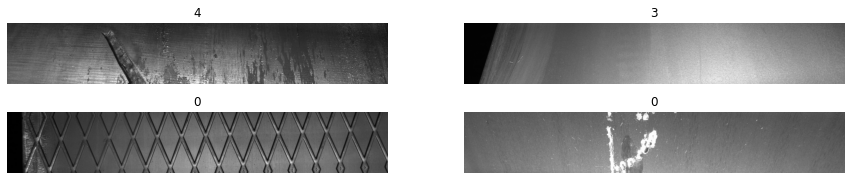

In [ ]:
dls.train.show_batch(figsize=(15, 3))

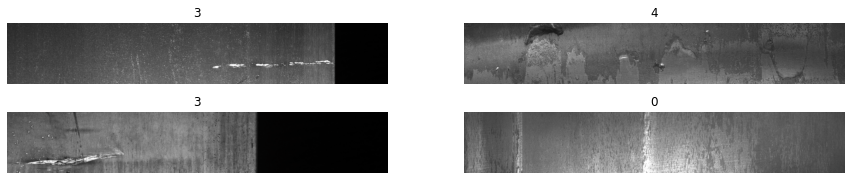

In [ ]:
dls.valid.show_batch(figsize=(15, 3))

In [ ]:
x, y = dls.train.one_batch()
x.shape, y.shape

(torch.Size([4, 3, 256, 1600]), torch.Size([4, 5]))

### Segmentation

To get a `DataLoaders` object for training segmentation FastAI models, we need to: 
- load the training images
- load the corrisponding labels (saved in `labels_dir` by the `preprocessing` module with the `create_mask` function)
- pair the images with labels with a `Dataset`
- split the dataset into training and validation and pair them with a `Datasets` object.
- for each dataset, create a `DataLoader` with a batch size and pair them with a `DataLoaders` object.

In [ ]:
x_tfms = Pipeline([ReadImagePathFromIndex, PILImage.create])
y_tfms = Pipeline([ReadRLEs(cols=[1,2,3,4]), MakeMask(), PILMask.create])
dsets = Datasets(train_pivot, [x_tfms, y_tfms])

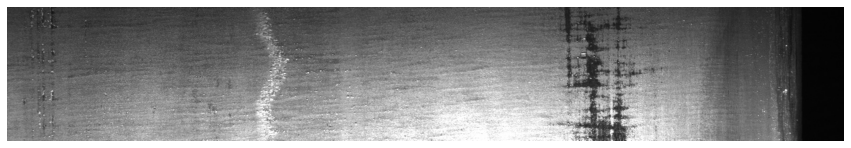

In [ ]:
# missing
elem = dsets[50]
show_image(elem[0], figsize=(15,5));

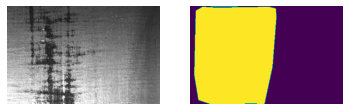

In [ ]:
# missing
resize=Resize((256,400))
show_images(resize(elem));

Albumentation transforms:

In [ ]:
# export
class AlbumentationsTransform(ItemTransform, RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, o):
        img, mask = o # TBD
        if self.idx == 0:
            aug = self.train_aug(image=np.array(img),mask=np.array(mask))
            aug_img = aug['image']
            aug_mask = aug['mask']
        else:
            aug = self.valid_aug(image=np.array(img),mask=np.array(mask))
            aug_img = aug['image']
            aug_mask = aug['mask']
        return PILImage.create(aug_img), PILMask.create(aug_mask)

In [ ]:
# export
def get_train_aug(): return alb.Compose([
    alb.CropNonEmptyMaskIfExists(256, 256, p=1., ignore_values=[0]),
    alb.OneOf([
        alb.VerticalFlip(p=0.5),
        alb.HorizontalFlip(p=0.5)], p=0.8),
    alb.RandomRotate90(p=0.5),
    alb.OneOf([
        alb.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        alb.GridDistortion(p=0.5),
        alb.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
    ], p=0.8)
])

def get_valid_aug(): return alb.Compose([alb.RandomCrop(256, 256)])

In [ ]:
# export
def SteelMaskBlock(codes=None, flatten_mask=False):
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    if not flatten_mask: batch_tfms += [ChannelMask]
    return TransformBlock(type_tfms=[MakeMask,PILMask.create], 
                          item_tfms=[AddMaskCodes(codes), ToTensor], 
                          batch_tfms=batch_tfms)

In [ ]:
#missing
itfms = [AlbumentationsTransform(get_train_aug(), get_valid_aug())]
block = DataBlock(blocks = (ImageBlock,SteelMaskBlock(codes=[1,2,3,4], flatten_mask=True)),
                  get_x = ReadImagePathFromIndex,
                  get_y = ReadRLEs(cols=[1,2,3,4]),
                  splitter = TrainTestSplitter(),
                  item_tfms = itfms)

In [ ]:
# missing
# uncomment to debug the dblock
# block.summary(train_pivot)

In [ ]:
#missing
dls = block.dataloaders(source=train_pivot, bs=4)

In [ ]:
#missing
xb, yb = next(iter(dls.train))
xb.shape, yb.shape

(torch.Size([4, 3, 256, 256]), torch.Size([4, 256, 256]))

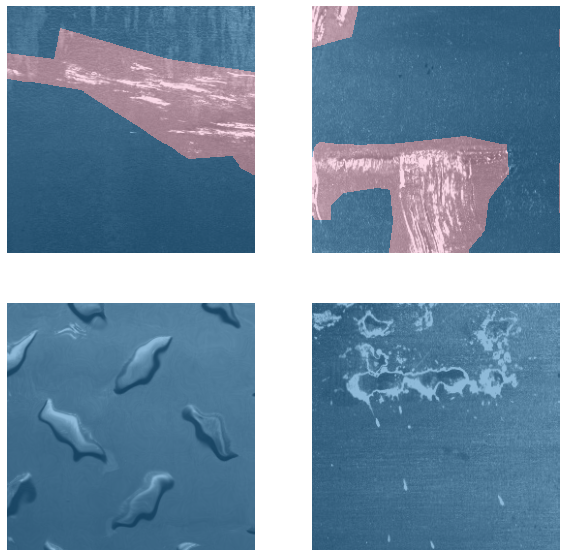

In [ ]:
#missing
dls.train.show_batch(figsize=(10,10))

In [ ]:
# export
@delegates(to=DataLoaders)
def get_segmnt_dls(source:pd.DataFrame=None, bs:int=16, size:tuple=None, 
                   train_aug:alb.Compose=None, valid_aug:alb.Compose=None, 
                   splitter:tuple=None, flatten_mask:bool=False, **kwargs):
    """
    Create a DataLoaders obj for segmentation models.
    
    Attributes:

        source: pd.DataFrame, the source file with labels, only `train_pivot` or its slices atm.
        
        bs: int, batch size for training and validation phases.
        
        size: tuple of ints, crops the images with this size, only squared sizes atm.
        
        train_aug, valid_aug: albumentations.core.composition.Compose, 
        List of augmentation to be applied over the training and validation batches
        
        splitter: tuple of indexes, idxs for split into training and validation
        
        flatten_mask: bool, if True returns a flatten mask of shape `size` for each image in the batch.
        Set to True for fastai models (`unet_learner`).
        
    """
    if source is None:    source=train_pivot
    if size is None:      size=(256,256)
    if train_aug is None: train_aug=get_train_aug()
    if valid_aug is None: valid_aug=get_valid_aug()
    if splitter is None:  splitter=TrainTestSplitter(test_size=0.2)
    
    # Albumentations tfms
    itfms = [AlbumentationsTransform(train_aug, valid_aug)]
    # Datablock
    block = DataBlock(
        blocks = (ImageBlock,SteelMaskBlock(codes=[1,2,3,4], 
                                            flatten_mask=flatten_mask)),
        get_x = ReadImagePathFromIndex,
        get_y = ReadRLEs(cols=[1,2,3,4]),
        splitter = splitter,
        item_tfms = itfms
    )
    return block.dataloaders(source=source, bs=bs, **kwargs)

In [ ]:
# missing
dls = get_segmnt_dls()
xb, yb = next(iter(dls.train))
xb.shape, yb.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 4, 256, 256]))

In [ ]:
#export
def get_segmentation_dls(bs, size, with_btfms=True, seed=42):
    """Deprecated function: Dataloaders from `train_path` folder"""
    warnings.warn("Deprecated function, use `get_segmnt_dls(flatten_mask=True)`")
    
    b_tfms = [Normalize.from_stats(*imagenet_stats)]

    if with_btfms:
        b_tfms += aug_transforms(
            size=size if size else (256, 1600),
            max_warp=.1,
            max_rotate=5.,
            max_lighting=0.1)

    def get_labels_from_img(p):
        return labels_path/f'{p.stem}_P.png'

    dblock = DataBlock(
        blocks=(ImageBlock, MaskBlock(codes=classes)),
        get_items=get_image_files,
        get_y=get_labels_from_img,
        splitter=RandomSplitter(valid_pct=0.2, seed=seed),
        batch_tfms=b_tfms)

    return dblock.dataloaders(train_path, bs=bs)

In [ ]:
# export
def get_segmentation_dls_from_df(train_df, bs, size, with_btfms=True, seed=42):
    """Deprecated function: Dataloaders from `train` DataFrame"""
    warnings.warn("Deprecated function, use `get_segmnt_dls(flatten_mask=True)`")
    
    def get_x(df):
        img_name = df["ImageId"]
        return train_path / str(img_name)

    def get_y(df):
        img_name = df["ImageId"].split(".")[0] + "_P.png"
        return labels_path / img_name

    b_tfms = [Normalize.from_stats(*imagenet_stats)]

    if with_btfms:
        b_tfms += aug_transforms(
            size=size if size else (256, 1600),
            max_warp=.1,
            max_rotate=5.,
            max_lighting=0.1)

    dblock = DataBlock(
        blocks=(ImageBlock, MaskBlock(codes=classes)),
        get_x=get_x,
        get_y=get_y,
        splitter=RandomSplitter(valid_pct=0.2, seed=seed),
        batch_tfms=b_tfms)

    return dblock.dataloaders(train_df, bs=bs)

In [ ]:
# missing
bs = 4
szs = (128, 800)
dls = get_segmentation_dls_from_df(train_multi, bs, szs)

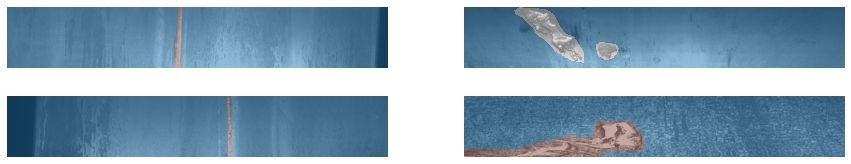

In [ ]:
# missing
dls.train.show_batch(figsize=(15, 3))

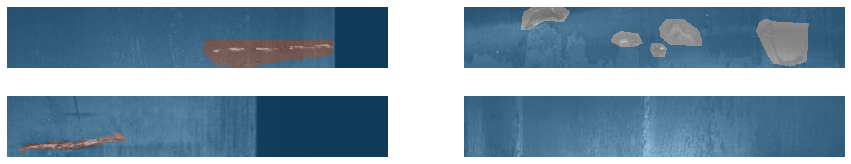

In [ ]:
# missing
dls.valid.show_batch(figsize=(15, 3))

In [ ]:
# missing
x, y = dls.train.one_batch()
x.shape, y.shape

((4, 3, 128, 800), (4, 128, 800))

In [ ]:
# missing
[torch.unique(y[i]) for i in range(bs)]

[TensorMask([0, 3]), TensorMask([0, 4]), TensorMask([0, 3]), TensorMask([0])]

## Pure Pytorch

Pure Pytorch `DataLoader` creation function from [this kernel](https://www.kaggle.com/rishabhiitbhu/unet-starter-kernel-pytorch-lb-0-88) (**deprecated**).

In [ ]:
# export
def get_train_dls(
        phase,
        mean=None,
        std=None,
        batch_size=8,
        num_workers=4,
    ):
    '''Returns dataloader for the model training.'''
    warnings.warn("Deprecated function, use `get_segmnt_dls()`")
    
    df = train_pivot
    if (mean is None) or (std is None):
        mean, std = imagenet_stats
        
    train_df, val_df = train_test_split(
        df, test_size=0.2, stratify=df["n"], random_state=69)
    
    df = train_df if phase == "train" else val_df
    image_dataset = SteelDataset(df, mean, std, phase)
    
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )

    return dataloader

In [ ]:
# missing
steel_dls = get_train_dls(phase='train')
test_eq(len(steel_dls), 1257)

In [ ]:
# missing
xb, yb = next(iter(steel_dls))
xb.shape, yb.shape

(torch.Size([8, 3, 256, 1600]), torch.Size([8, 4, 256, 1600]))

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_metadata.ipynb.
Converted 02_masks.ipynb.
Converted 03_datasets.ipynb.
Converted 04_dataloaders.ipynb.
Converted 05_metrics.ipynb.
Converted 06_loss.ipynb.
Converted 07_trainer.ipynb.
Converted 08_predict.ipynb.
Converted 09_visualize.ipynb.
Converted 10_fastai.classifier.ipynb.
Converted 11_fastai.seg_unet_resnet34.ipynb.
Converted 12_fastai.seg_unet_xresnext34.ipynb.
Converted 13_torch.seg_fpn_resnet34.ipynb.
Converted 14_torch.seg_unet_resnet34.ipynb.
Converted 15_torch.seg_unet_resnet18.ipynb.
Converted 21_ensemble_unet_fpn_resnet34.ipynb.
Converted index.ipynb.
